In [1]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import rebound
import numpy as np
from numpy import pi as PI
from numpy import sin
from numpy.random import rand
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (4, 3)

In [2]:
N_testparticle = 100

- 怎么将小天体的轨道中心设置在太阳？在`sim.add`里面使用`primary=sim.particles['sun']`得到的结果不对劲。
- 在确定flyby和黄道面的倾角之后，如何确定flyby近心点的位置？（不同的近心点位置甚至会有穿过黄道面1次和2次的区别）

### 生成小天体的a和inc分布

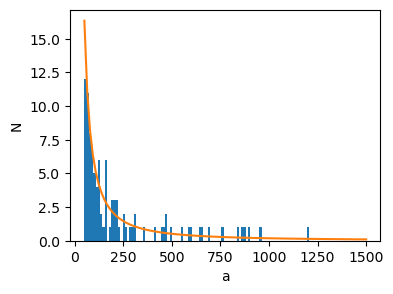

In [3]:
# sample a
a_pdf_func = lambda x:x**(-1.5)

# np.random.seed(0)
a_rand = np.random.rand(5000)*1450 + 50 # a in [50, 1500]
a_pdf = a_pdf_func(a_rand)
a_pdf = a_pdf/a_pdf.sum()
a = np.random.choice(a_rand, size=N_testparticle, replace=True, p=a_pdf)

plt.hist(a, bins=100)
x = np.linspace(50, 1500, 100)
x_pdf = a_pdf_func(x)
x_pdf = x_pdf/x_pdf.sum()
plt.plot(x, x_pdf*N_testparticle)
plt.ylabel("N")
plt.xlabel("a")
plt.show()

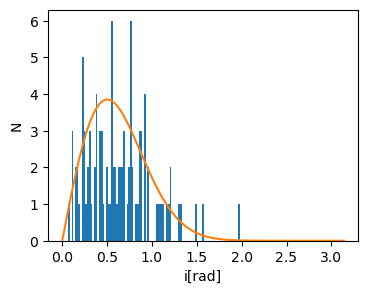

In [4]:
# sample i

inc_pdf_func = lambda x:sin(x)*norm.pdf(x, loc=0, scale=15/180*2*PI)

inc_rand = np.random.rand(5000)*PI # i in [0, 90]
inc_pdf = inc_pdf_func(inc_rand)
inc_pdf = inc_pdf/inc_pdf.sum()
inc = np.random.choice(inc_rand, size=N_testparticle, replace=True, p=inc_pdf)

plt.hist(inc, bins=100)
x = np.linspace(0, PI ,100)
x_pdf = inc_pdf_func(x)
x_pdf = x_pdf/x_pdf.sum()
plt.plot(x, x_pdf*N_testparticle)
plt.ylabel("N")
plt.xlabel("i[rad]")
plt.show()


In [4]:
sim = rebound.Simulation()
sim.add(m=1., hash='sun')
sim.add(a=-1, e=1.1, omega=np.pi)
sim.widget(size=(400,400))

REBOUND Webserver listening on http://localhost:1234 ...



REBOUND Webserver error: Did not get request.

REBOUND Webserver error: Did not get request.


### sim模拟设置

In [5]:
# sim.stop_server()
# del sim

# sim.start_server(port=1234)

# sim.heartbeat=heratbeat
sim.integrator = "whfast"
sim.dt = 0.05

sim.add(m=1., hash='sun')
sim.add(m=1., x=15000, y=1075, vx=-0.05, hash='flyby')
# 已知v_inf和q求解b(y)，注意要保证轨道是抛物线（E>0）


sim.status(showAllFields=False, showParticles=False)
sim.widget(size=(400,400))

---------------------------------
REBOUND version:     	4.3.2
REBOUND built on:    	Feb 19 2024 16:09:36
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.050000
---------------------------------
REBOUND Webserver listening on http://localhost:1234 ...


In [6]:
# flyby_inc = 85

for j in range(N_testparticle):
    q = rand()*20+5
    while q>a[j]:
        q = rand()*20+5
    # print(q)
    # print(a[i])
    e = 1-q/a[j]
    # print(e)
    # look in OrbitalElements.ipynb
    sim.add(primary=sim.particles['sun'], a=a[j], e=e, inc=inc[j], 
            l=rand()*2.*PI, pomega=rand()*2.*PI, Omega=rand()*2.*PI)
    # l = Omega + omega + M, the position of the particle in the orbit, well defined for e=0
    # pomega = Omega + omege, is the angel from the x-axis to the pericenter, well defined for i=0

sim.status(showAllFields=False, showParticles=False)

---------------------------------
REBOUND version:     	4.3.2
REBOUND built on:    	Feb 19 2024 16:09:36
Number of particles: 	102
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.050000
---------------------------------


In [7]:
sim.move_to_com()

In [8]:
a_initial = np.zeros(N_testparticle)
e_initial = np.zeros(N_testparticle)
q_initial = np.zeros(N_testparticle)
inc_initial = np.zeros(N_testparticle)
pomega_initial = np.zeros(N_testparticle)

for i in range(N_testparticle):
    a_initial[i] = sim.particles[i+2].a
    q_initial[i] = sim.particles[i+2].a*(1-sim.particles[i+2].e)
    e_initial[i] = sim.particles[i+2].e
    inc_initial[i] = sim.particles[i+2].inc
    pomega_initial[i] = sim.particles[i+2].pomega


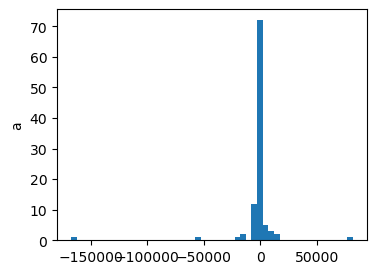

In [9]:
plt.hist(a_initial, bins=50)
plt.ylabel('a')
plt.show()

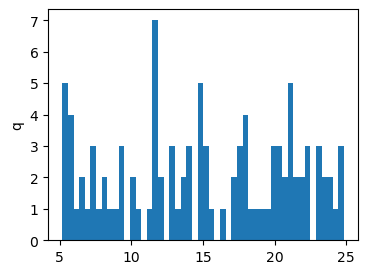

In [92]:
plt.hist(q_initial, bins=50)
plt.ylabel('q')
plt.show()

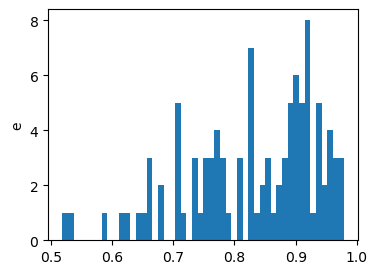

In [93]:
plt.hist(e_initial, bins=50)
plt.ylabel('e')
plt.show()

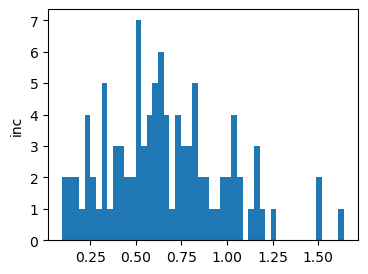

In [96]:
plt.hist(inc_initial, bins=50)
plt.ylabel('inc')
plt.show()

In [97]:
sim.N_active = 2

Next, let's do the simulation. We will run it for 200 orbits of the planet which, in our units of $G=1$, is $t_{\rm max} = 200\cdot2\pi$. While we run the simulation, we'll keep store the position of all test particles 10 times during the interval.

In [98]:
sim.integrate(1000.*2.*PI)

### plot出结果

In [100]:
a_final = np.zeros(N_testparticle)
e_final = np.zeros(N_testparticle)
q_final = np.zeros(N_testparticle)
inc_final = np.zeros(N_testparticle)
pomega_final = np.zeros(N_testparticle)

for i in range(N_testparticle):
    particle = sim.particles[i+2]
    a_final[i] = particle.a
    q_final[i] = particle.a*(1-particle.e)
    e_final[i] = particle.e
    inc_final[i] = particle.inc
    pomega_final[i] = particle.pomega


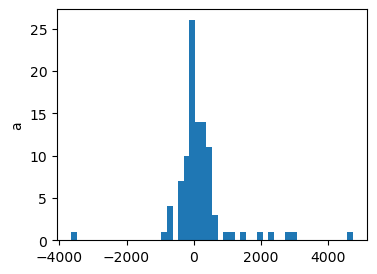

In [105]:
plt.hist(a_final[a_final<5000], bins=50)
plt.ylabel('a')
plt.show()

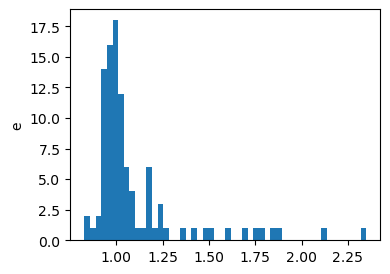

In [106]:
plt.hist(e_final, bins=50)
plt.ylabel('e')
plt.show()

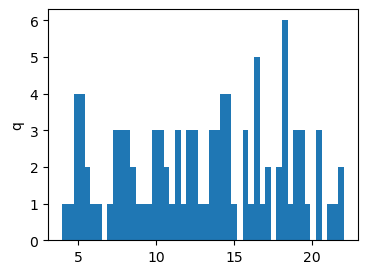

In [107]:
plt.hist(q_final, bins=50)
plt.ylabel('q')
plt.show()

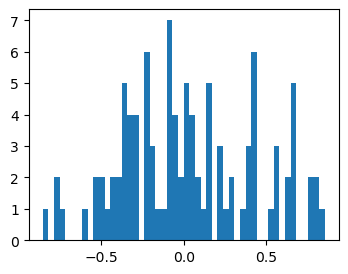

In [109]:
plt.hist(pomega_final/2/PI, bins=50)
plt.show()

We now plot the test particles' positions.

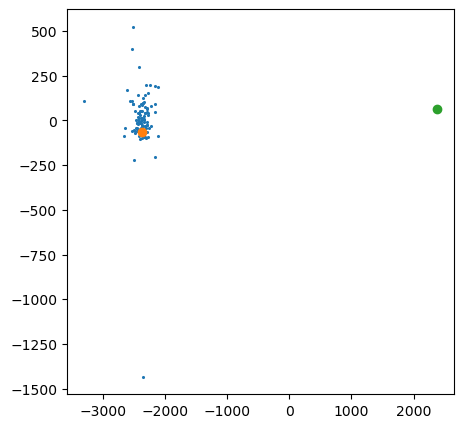

In [17]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
# ax.set_xlim([-1e3,1e3])
# ax.set_ylim([-1e3,1e3])
plt.scatter(xy[0,:,0],xy[0,:,1],marker=".",linewidth=0,s=20)
plt.scatter(sim.particles[0].x, sim.particles[0].y)
plt.scatter(sim.particles[1].x, sim.particles[1].y)

In [19]:
for i in range(1):
    print(i)

0


One can see that some particles changed their orbits quite significantly, while others seem to stay roughly on circular orbits. To investigate this a bit further, we now calculate and plot the relative change of the test particles' semi-major axis over the duration of the simulation. We'll plot it as a function of the initial period ratio $r=P_{\rm test particle}/P_{\rm planet}$ for which we make use of Kepler's law, $P = 2\pi\sqrt{a^3/GM}$.

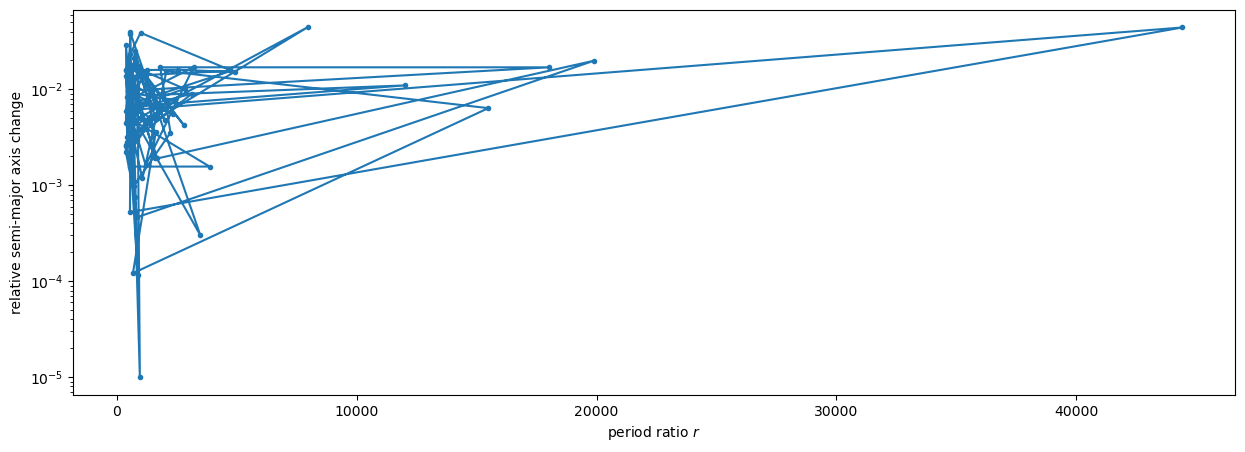

In [ ]:
orbits = sim.orbits()[1:]
a_final = [o.a for o in orbits]
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
ax.set_xlabel(r"period ratio $r$")
ax.set_ylabel("relative semi-major axis change")
plt.plot(np.power(a,1.5),(np.fabs(a_final-a)+1.0e-16)/a,marker=".");

Very close to the planet test particles change their semi-major axis by order unity. These particles have a close encounter with the planet and get scattered.

We also see two peaks at $r=2$ and $r=3$. These correspond to mean motion resonances. We can also see the mean motion resonances by plotting the eccentricities of the particles. 

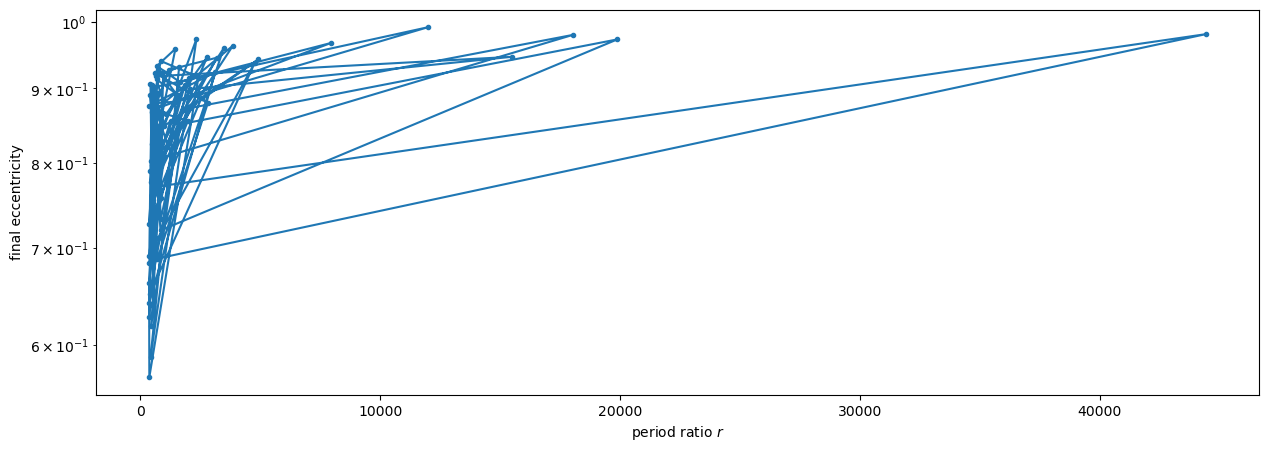

In [ ]:
e_final = np.array([o.e for o in orbits])
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
#ax.set_ylim([0,1])
ax.set_yscale('log')
ax.set_xlabel(r"period ratio $r$")

ax.set_ylabel("final eccentricity")
plt.plot(np.power(a,1.5),e_final+1.0e-16,marker=".");

Once again, we see peaks at $r=2$ and $r=3$, corresponding to the 2:1 and 3:1 mean motion resonance. You can even see a hint of an effect at $r=4$, the 4:1 mean motion resonance.

In the above example, the planet did not change its semi-major axis as the test particles have zero mass and do not affect any other particles. 

In [ ]:
print(sim.orbits()[0].a)

1.0000000000000027


Let us change this assumption by allow the test particles to have a small mass and influence the planet. Test particles do still not influence other test particles. This setup is referred to as type 1 in REBOUND.

In [ ]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1, e=0.05)
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 0.05
N_testparticle = 1000
a_initial = np.linspace(1.1, 3, N_testparticle)
for a in a_initial:
    sim.add(a=a,f=np.random.rand()*2.*np.pi, m=1e-7)

As above, we set `N_active` to the number of massive bodies. We also set the `testparticle_type` to 1, which allows interactions between test particles and massive particles, but not between test particles themselves. This is similar to what MERCURY calls small bodies.

In [ ]:
sim.N_active = 2
sim.testparticle_type = 1

If we integrate this simulation forwards in time and output the semi-major axis of the planet, we can see that it changed slightly from the initial $a=1$ due to interactions with the test particles. 

In [ ]:
sim.integrate(t_max)
print(sim.orbits()[0].a)

0.9798939680007318
